## Using the em/feat/muinversion branch of SimPEG (http://github.com/simpeg/simpeg)

In [1]:
from CasingSimulations import * 
%matplotlib inline

In [2]:
directory = 'UniformBackground1kmCasing_upto5Hz_10ohmmback'
cpfile = "CasingProperties.json"
resultsfile = "MagneticPermeabilityImpacts.hdf5"
rerun = True

# Model Parameters

In [3]:
casing_l = 1000.
dsz = -casing_l + 50. 
freqs = [1e-1, 0.5, 1, 2, 5]
sigmaback=1e-1

In [4]:
# Save or load Results
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

if rerun is True:   
    cp = CasingProperties(casing_l=casing_l, dsz=dsz, sigmaback=sigmaback, sigmalayer=sigmaback)
    cp.freqs = freqs
else:   
    with open(cp_file, 'r') as outfile:   
        cp = CasingProperties.deserialize(json.load(outfile))

In [5]:
CMesh = CasingMesh(cp)
CMesh.npadx2 = CMesh.npadx2 - 3
CMesh.npadzu = CMesh.npadzu - 3
CMesh.npadzd = CMesh.npadzd - 3
mesh = CMesh.mesh

In [6]:
print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(cp.sigmaback*f) for f in cp.freqs])
print([500./np.sqrt(cp.sigmacasing*f) for f in cp.freqs])

Cyl Mesh Extent xmax: 208853.54563,: zmin: -183013.550756, zmax: 182014.050756
2389520
[5000.0, 2236.0679774997898, 1581.1388300841895, 1118.0339887498949, 707.10678118654744]
[0.67419986246324204, 0.30151134457776363, 0.21320071635561044, 0.15075567228888181, 0.095346258924559224]


# plot model

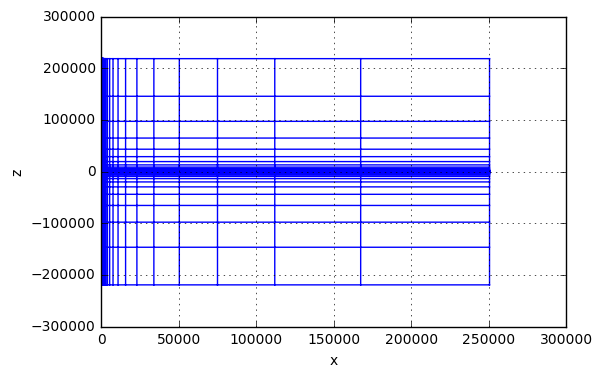

In [7]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [8]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [9]:
muModelInd = 1

sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, cp.muModels[muModelInd]*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [10]:
cp.sigmaback

0.1

In [11]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 23.9 s, sys: 688 ms, total: 24.6 s
Wall time: 25.8 s


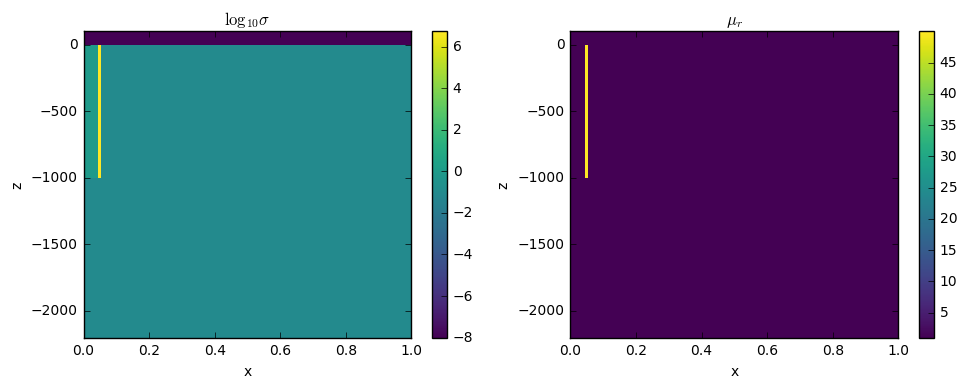

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, mu, xlim=[0.,1.], zlim=[-2200., 100.], ax=ax)
# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [13]:
# down-holeSource
dhSrc = DownHoleCasingSrc(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)
thSrc = TopCasingSource(mesh, np.r_[0.,0.,0], cp.src_b, cp.casing_a, cp.freqs)

(-951, -949)

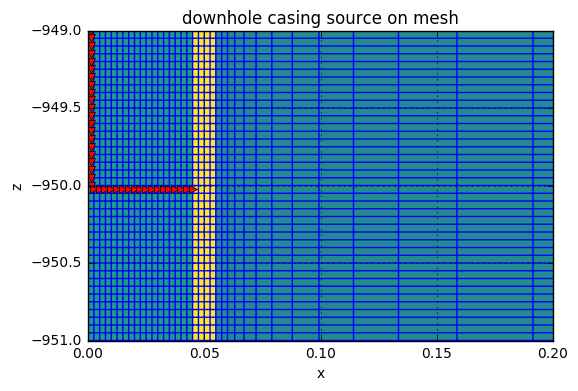

In [14]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
dhSrc.plotSrc(ax=ax)

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.2])
ax.set_ylim([-951, -949])

# fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [15]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=muMap)
survey = FDEM.Survey(dhSrc.s_e + thSrc.s_e)
prob.solver = Solver
prob.pair(survey)

In [16]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
        cp.casing_z[0], cp.casing_z[1]
    ]

In [17]:
cp.muModels = [1., 50., 100., 200.]
fields = {}

In [18]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [ ]:
results.keys()

[]

In [ ]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))
        
        # Save parameters used to produce these fields
        with open(cp_file, 'w') as outfile:
            json.dump(cp.serialize(), outfile)

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

solving mu = 1mu_0


In [ ]:
def vecplot_j(muind, freqind, reim='real', th_bh = 'bh'):
    fig, ax = plt.subplots(1,1, figsize=(6,8))
    src = survey.getSrcByFreq(survey.freqs[freqind])
    src = src[0] if th_bh == 'bh' else src[1]
    mur = cp.muModels[muind]
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
    ax1 = plotCurrentDensity(
        mesh, fields[mur][src, 'j'], csx=0.0001, csz=5., 
        xmax=0.15, zmin=10., zmax=-1500., real_or_imag=reim, mirror=True, ax=ax, fig=fig, saveFig=True
    )
    return ax1

w = widgets.interactive(
        vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1, continuousUpdate=False),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1, continuousUpdate=False),
        reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False), 
        th_bh=widgets.ToggleButtons(options=['th', 'bh'], continuousUpdate=False)
)
w
#ax.axis('equal', adjustable='box')

In [ ]:
%%time 

IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, survey) #sigma_m, indActive, casingMap)

In [ ]:
def plotMe_freq(
    muopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    
    plot_currents_over_freq(
        IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim, 
        ax=ax, logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  
    plt.show()

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False), 
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False),
)


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

plot_currents_over_freq(
    IxCasing, IzCasing, cp, mesh, mur=50., real_or_imag='real', 
    ax=ax, logScale=True, srcinds=[0], ylim_0=[1e-2, 1.], ylim_1=[6e-5, 1.5e-4]
) 

ax[0].set_xlabel('z (m)', fontsize=13)
ax[1].set_xlabel('z (m)', fontsize=13)

ax[0].set_ylabel('$I_z$ (A)', fontsize=13)
ax[1].set_ylabel('$I_x$ (A)', fontsize=13)

ax[0].set_title('Vertical Current in Casing')
ax[1].set_title('Horizontal Current in Casing')

plt.tight_layout()

fig.savefig('currents_in_casing.png', dpi=300)

5.0 Hz


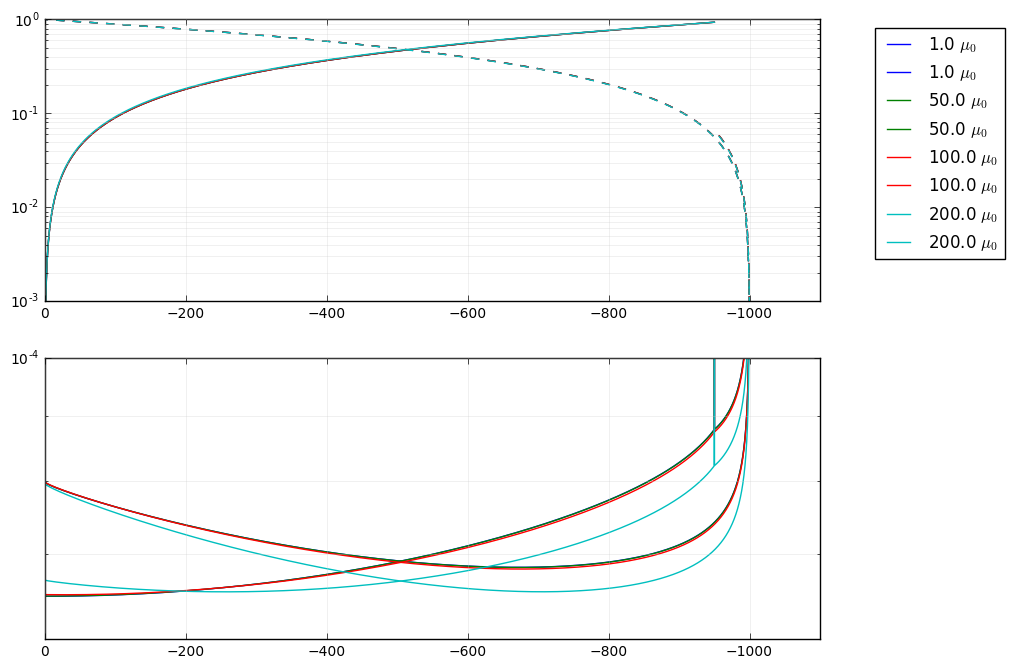

In [24]:
def plotMe_mu(
    freqopt, reim, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
    plot_currents_over_mu(
        IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim,
        logScale=logScale, srcinds=srcinds, ylim_0=ylim_0, ylim_1=ylim_1
    )  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuousUpdate=False),
    subtract=widgets.ToggleButtons(options=[None, 1], continuousUpdate=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-3, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1, continuousUpdate=False),
    ylim_1l=widgets.FloatText(6e-5, continuousUpdate=False),
    ylim_1u=widgets.FloatText(1e-4, continuousUpdate=False)
)

w

5.0 Hz


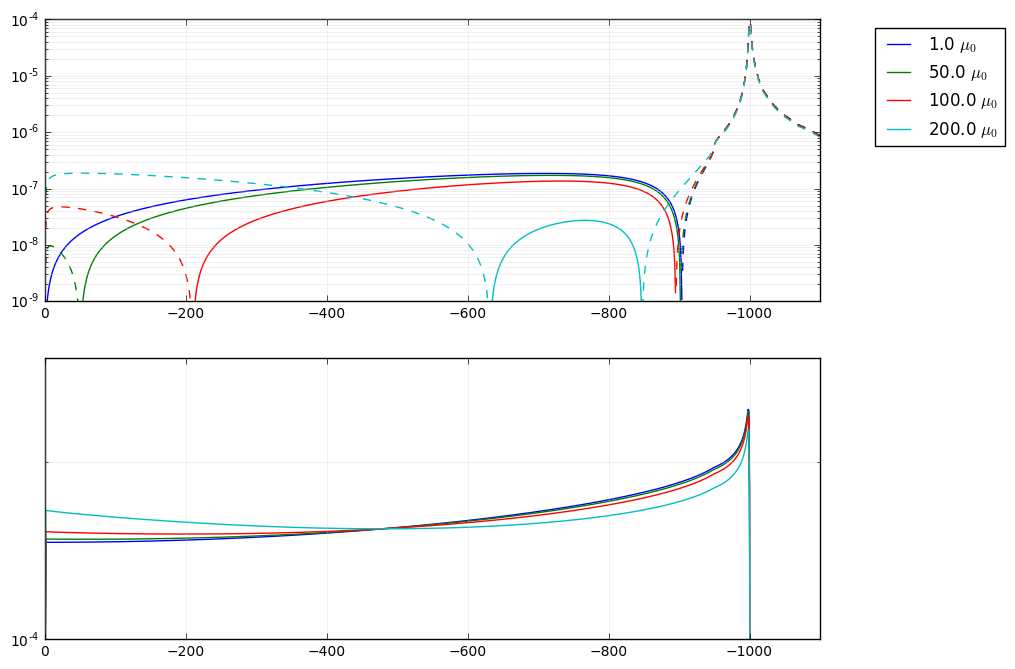

In [25]:
def plotMe_j_mu_z(
    freqopt, reim, r, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_z(
        cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, srcinds=srcinds,
        real_or_imag=reim, ax=ax, ylim_0 = ylim_0, ylim_1 = ylim_1, logScale=logScale
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    r=widgets.FloatText(value=1., continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-9, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1l=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1u=widgets.FloatText(3e-4, continuousUpdate=False)
)

mu = 50.0 mu_0


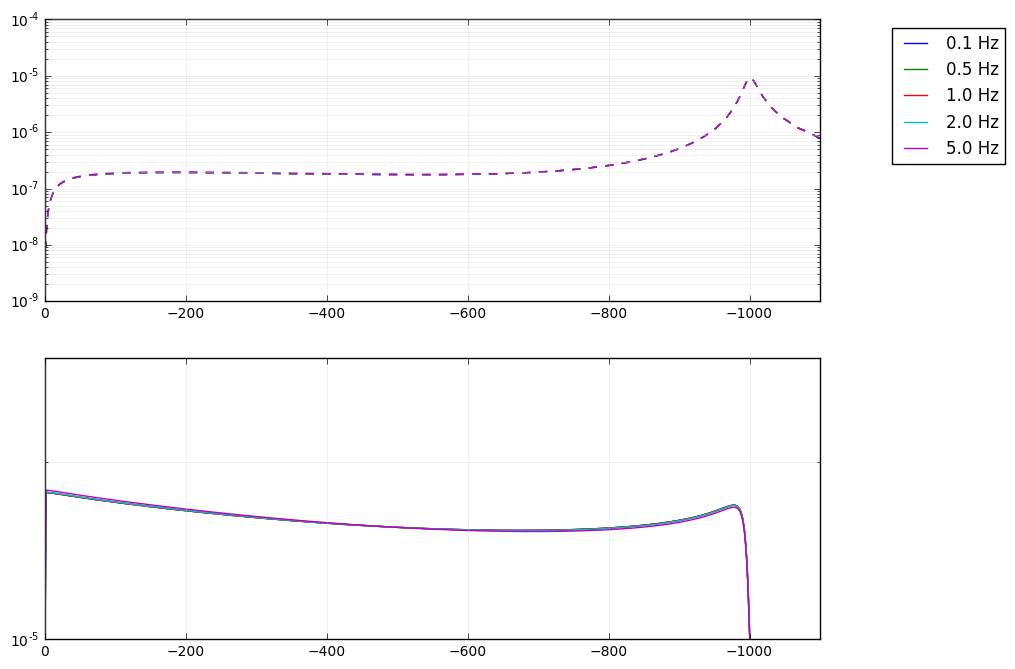

In [26]:
def plotMe_j_freq_z(
    muind, reim, r, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    mur = cp.muModels[muind]
    
    ylim_0 = [ylim_0l, ylim_0u]
    ylim_1 = [ylim_1l, ylim_1u]
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_freq_z(
        cp, fields, mesh, survey, mur, subtract=subtract, r=r, srcinds=srcinds,
        real_or_imag=reim, ax=ax, ylim_0 = ylim_0, ylim_1 = ylim_1, logScale=logScale
    )  
#     ax[1].set_ylim([1e-4, 3e-4])

widgets.interact(
    plotMe_j_freq_z, 
    muind=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuousUpdate=False), 
    r=widgets.FloatText(value=1., continuousUpdate=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1]),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False], continuousUpdate=False),
    ylim_0l=widgets.FloatText(1e-9, continuousUpdate=False),
    ylim_0u=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1l=widgets.FloatText(1e-4, continuousUpdate=False),
    ylim_1u=widgets.FloatText(3e-4, continuousUpdate=False)
)

mu = 1 mu_0


NameError: global name 'freqind' is not defined

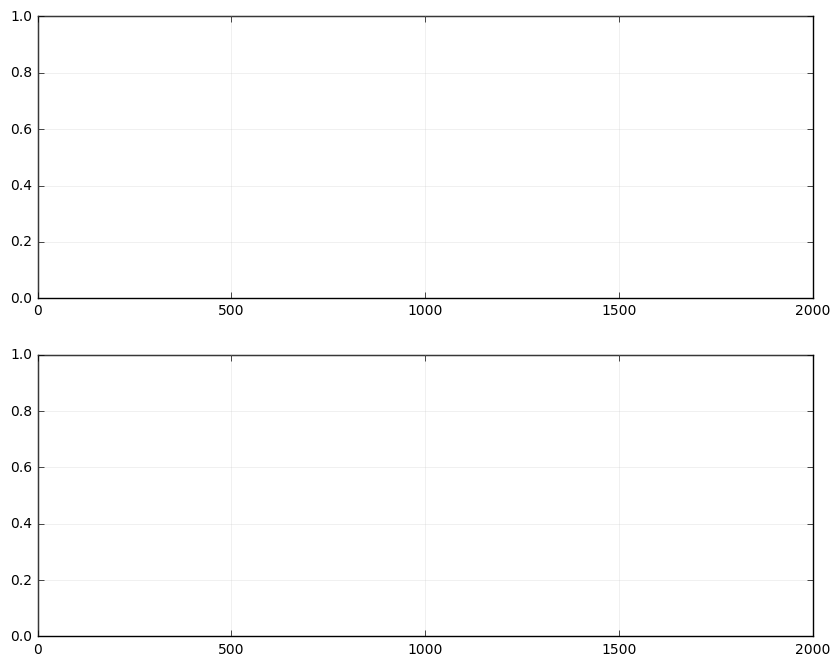

In [28]:
def plotMe_j_mu_x(
    freqopt, reim, z, subtract=None, th=True, bh=True, logScale=True, 
    ylim_0l=-1., ylim_0u=1., ylim_1l=6e-5, ylim_1u=1e-4
):
    ylim_0 = None #[ylim_0l, ylim_0u]
    ylim_1 = None #[ylim_1l, ylim_1u]
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    srcinds = []
    if bh is True: 
        srcinds += [0]
    if th is True:
        srcinds += [1]
        
    plot_j_over_mu_x(
        cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax,
        srcinds=srcinds, logScale=logScale, ylim_0=ylim_0, ylim_1=ylim_1
    )
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False),
    th=widgets.Checkbox(True),
    bh=widgets.Checkbox(True),
    logScale=widgets.ToggleButtons(options=[True, False]),
    ylim_0l=widgets.FloatText(1e-9),
    ylim_0u=widgets.FloatText(1e-4),
    ylim_1l=widgets.FloatText(1e-4),
    ylim_1u=widgets.FloatText(3e-4)
)
j_over_x

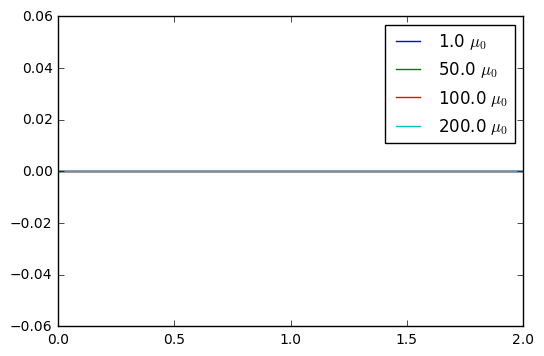

In [33]:
fig, ax = plt.subplots(1,1)
col = ['b', 'g', 'r', 'c', 'm', 'y']

for mur in cp.muModels:
    ax.plot(np.zeros(3), label='{} $\mu_0$'.format(mur))
ax.legend()

fig.savefig('mu_legend', dpi=300)